In [3]:
import numpy as np
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
import pickle
from numpy import genfromtxt
import pandas as pd
from joblib import Parallel, delayed
import multiprocessing as mp
import scipy.io
from tqdm import tqdm_notebook as tqdm
import h5py
import math

In [4]:
import sys
from mgcpy.independence_tests.dcorr import DCorr
from mgcpy.benchmarks.hypothesis_tests.two_sample_test.power_dimension import power_given_data
from mgcpy.benchmarks.simulations import *
from mgcpy.independence_tests.mgc import MGC
from mgcpy.independence_tests.rv_corr import RVCorr
from mgcpy.independence_tests.hhg import HHG
from mgcpy.independence_tests.kendall_spearman import KendallSpearman

In [5]:
simulations = {'joint_normal': (joint_sim, 4), 'sine_4pi': (sin_sim, 12), 'sine_16pi': (sin_sim, 13), 
               'multi_noise': (multi_noise_sim, 19), 'diamond': (square_sim, 18), 'log': (log_sim, 10), 
               'multi_indept': (multi_indep_sim, 20), 'square': (square_sim, 14)}
#{'step': (step_sim, 5), 'spiral': (spiral_sim, 8), 'quadratic': (quad_sim, 6), 'w_shape': (w_sim, 7), 
               #'bernoulli': (ubern_sim, 9), 'linear': (linear_sim, 1), 'exponential': (exp_sim, 2), 'cubic': (cub_sim, 3)}

In [6]:
def power_vs_dimension_parallel(params_dict):
    dims = [1, 3, 4, 5, 7, 9, 10]
    estimated_power = np.zeros(len(dims))
    test = params_dict['independence_test']
    sim = params_dict['simulation_type']
    print(sim, test.get_name())
    
    for i in range(len(dims)):
        estimated_power[i] = power_given_data(test, sim, num_samples=100, num_dimensions=dims[i], translate=0.5)
    
    np.savetxt('{}_{}_dimension_matlab_new.csv'.format(sim, test.get_name()), estimated_power, delimiter=',')
    print('{} {} finished'.format(sim, test.get_name()))
    return (params_dict, estimated_power)

In [7]:
def fill_params_dict_list_dim():
    mcorr = DCorr(which_test='unbiased')
    dcorr = DCorr(which_test='biased')
    mantel = DCorr(which_test='mantel')
    mgc = MGC()
    pearson = RVCorr(which_test='pearson')
    rv_corr = RVCorr(which_test='rv')
    cca = RVCorr(which_test='cca')
    independence_tests = [mcorr, dcorr, mantel, pearson, rv_corr, cca]
    
    params_dict_list = []
    for sim_name, sim_func in simulations.items():
        for test in independence_tests:
            params_dict = {'independence_test': test, 'simulation_type': sim_func[1]}
            params_dict_list.append(params_dict)
    return params_dict_list

In [6]:
%%time
params_dict = fill_params_dict_list_dim()
print(type(params_dict))
pool = mp.Pool(mp.cpu_count()-1)
results = pool.map(power_vs_dimension_parallel, params_dict)

<class 'list'>
4 unbiased
12 mantel
4 rv
4 rv finished
4 cca
4 cca finished
12 unbiased
12 mantel finished
12 pearson
12 pearson finished
12 rv
4 unbiased finished
4 biased
12 rv finished
12 cca
12 cca finished
13 unbiased
12 unbiased finished
12 biased
4 biased finished
4 mantel
13 unbiased finished
13 biased
12 biased finished
13 rv
4 mantel finished
4 pearson
13 rv finished
13 cca
4 pearson finished
19 mantel
13 cca finished
19 unbiased
13 biased finished
13 mantel
19 mantel finished
19 pearson
19 pearson finished
19 rv
13 mantel finished
13 pearson
19 unbiased finished
19 biased
19 rv finished
19 cca
13 pearson finished
18 unbiased
19 cca finished
18 rv
18 rv finished
18 cca
18 cca finished
10 unbiased
19 biased finished
10 mantel
18 unbiased finished
18 biased
10 mantel finished
10 pearson
10 pearson finished
10 rv
10 unbiased finished
10 biased
10 rv finished
10 cca
18 biased finished
18 mantel
10 cca finished
20 unbiased
10 biased finished
20 rv
18 mantel finished
18 pearson
20 

In [8]:
def plot_all_curves():
    simulation_names = ['linear', 'exponential', 'cubic','joint_normal', 'step', 'quadratic', 'w_shape', 'spiral', 
                         'bernoulli', 'log', 'fourth_root', 'sine_4pi',
                       'sine_16pi', 'square', 'two_parabolas', 'circle', 'ellipse', 'diamond', 'multi_noise',
                        'multi_indept']
        
        
    fig, ax = plt.subplots(nrows=4, ncols=5, figsize=(14,12)) 
    simulation_type=0
    for i, row in enumerate(ax):
        for j, col in enumerate(row):
            sim_name = simulation_names[simulation_type]
            simulation_type += 1
            tests = ['mgc', 'unbiased', 'biased', 'mantel', 'pearson', 'rv', 'cca']
            #mgc_power = np.genfromtxt('{}_mgc_angle_matlab_new.csv'.format(simulation_type), delimiter=',')

            for test in tests:
                power = np.genfromtxt('{}_{}_dimension_matlab_new.csv'.format(simulation_type, test), delimiter=',')
                x_axis = [1,3,4,5,7,9,10]
                col.plot(x_axis, power, label=test)
                col.set_ylim(-0.25, 1.25)
                col.set_yticks([-0.25, 0, 0.25, 0.50, 0.75, 1.00])
                col.set_title(sim_name) 
    plt.legend()
    plt.subplots_adjust(hspace=.75)
    fig.suptitle('Power of Changing Dimension')
    plt.savefig('power_curves_dimension_trial')

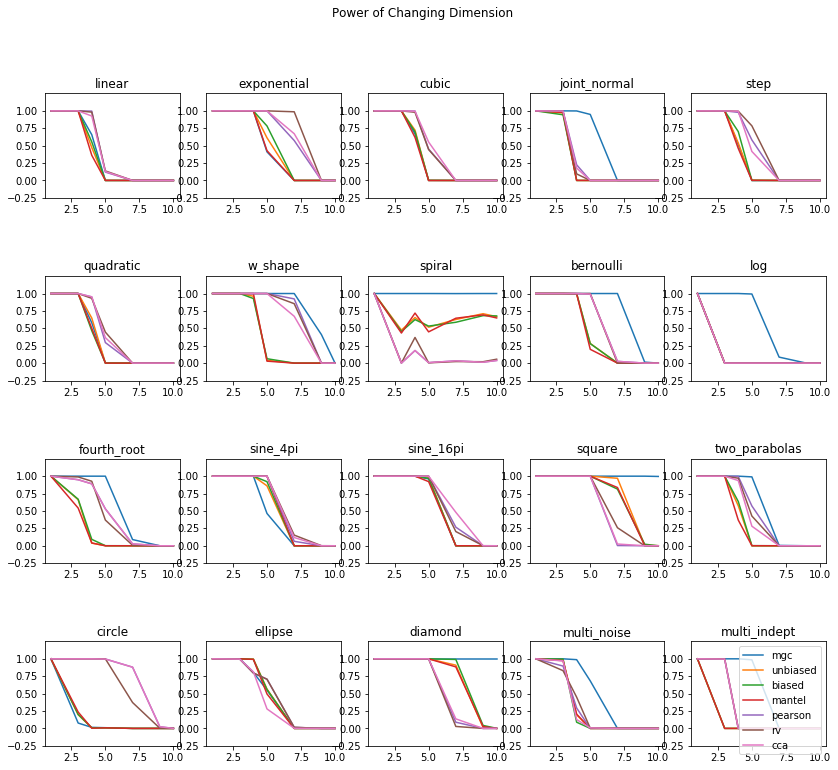

In [9]:
plot_all_curves()